In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Subset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

BATCH_SIZE=2
EPOCH=50
LEARNING_RATE=0.001

cuda:0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [8]:
import random
min_class_limit=4500
# Maximum number of samples in the train set
train_limit = None
# Maximum number of samples in the val set
val_limit = None

# Create the original datasets and dataloaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
    ])
}

data_dir = 'C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/data/BIRADS_split'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# Find the number of classes
num_classes = len(train_dataset.classes)
class_names=train_dataset.classes

# Select 5000 images from each class
selected_indices = []
for i in range(num_classes):
    class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
    class_indices = random.sample(class_indices, min(len(class_indices), min_class_limit))
    selected_indices.extend(class_indices)

# Select the specified number of samples from the train set
if train_limit is not None:
    selected_indices = selected_indices[:train_limit]

# Create new Subsets using the selected indices
train_subset = Subset(train_dataset, selected_indices)
val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

# Create new DataLoaders for the Subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Update the dataset_sizes dictionary
dataset_sizes = {
        'train': len(train_subset),
        'val': len(val_subset)
    }
image_datasets = {
        'train': train_subset,
        'val': val_subset
    }
dataloaders={}
dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader

dataset_sizes

{'train': 11486, 'val': 5401}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(3,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):
    
    selected_indices = []
    for i in range(num_classes):
        class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
        class_indices = random.sample(class_indices, min(len(class_indices), 5000))
        selected_indices.extend(class_indices)

    # Select the specified number of samples from the train set
    if train_limit is not None:
        selected_indices = selected_indices[:train_limit]

    # Create new Subsets using the selected indices
    train_subset = Subset(train_dataset, selected_indices)
    val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

    # Create new DataLoaders for the Subsets
    train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader
    
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                # Calculate and plot confusion matrix
                y_true = []
                y_pred = []

                model.eval()

                with torch.no_grad():
                    for inputs, labels in dataloaders['val']:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        y_true += labels.tolist()
                        y_pred += preds.tolist()

                cm = confusion_matrix(y_true, y_pred)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted labels')
                plt.ylabel('True labels')
                plt.title('Confusion matrix')
                plt.show()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [16]:
# A dictionary of models.

modeller={
    'birads_split_resnet50':models.resnet50(pretrained=True)
}
try:
    os.mkdir('./modelPerformance')
except:
    print('Dosyalar var')

Dosyalar var


In [12]:
models.resnet50(pretrained=True).fc

Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
model_ft = models.resnet50(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())
#model_ft.features.conv0=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Dosya var
Epoch 1/50
----------


100%|██████████| 5743/5743 [10:35<00:00,  9.04it/s]


train Loss: 1.0565 Acc: 0.4709


100%|██████████| 2700/2700 [01:48<00:00, 24.89it/s]


val Loss: 0.8537 Acc: 0.6989


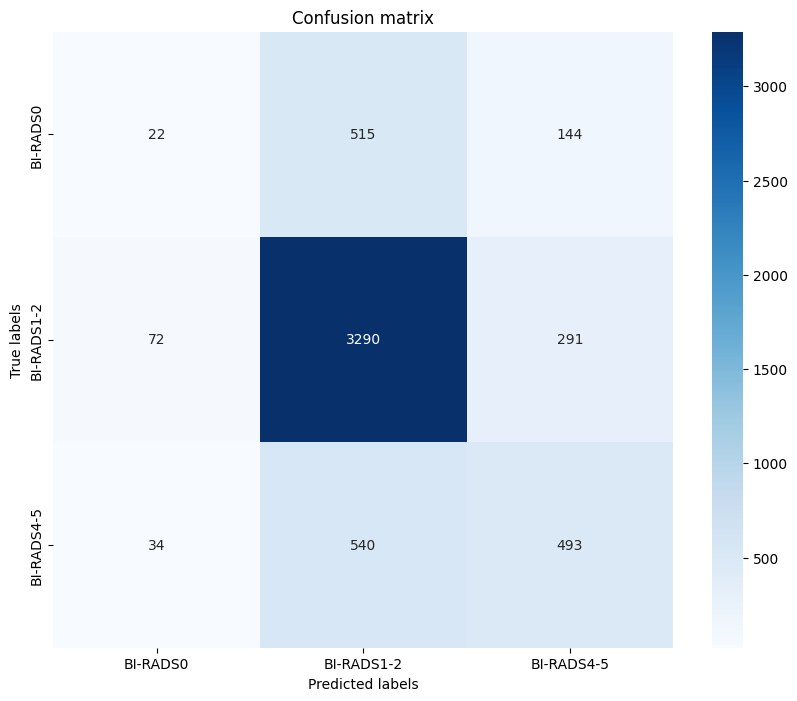


Epoch 2/50
----------


100%|██████████| 5743/5743 [09:31<00:00, 10.05it/s]


train Loss: 1.0274 Acc: 0.5093


100%|██████████| 2700/2700 [01:46<00:00, 25.23it/s]


val Loss: 0.8707 Acc: 0.6982

Epoch 3/50
----------


100%|██████████| 5743/5743 [09:25<00:00, 10.15it/s]


train Loss: 0.9935 Acc: 0.5393


100%|██████████| 2700/2700 [01:45<00:00, 25.64it/s]


val Loss: 0.8733 Acc: 0.6789

Epoch 4/50
----------


100%|██████████| 5743/5743 [09:16<00:00, 10.32it/s]


train Loss: 0.9737 Acc: 0.5607


100%|██████████| 2700/2700 [01:47<00:00, 25.19it/s]


val Loss: 0.8509 Acc: 0.7056


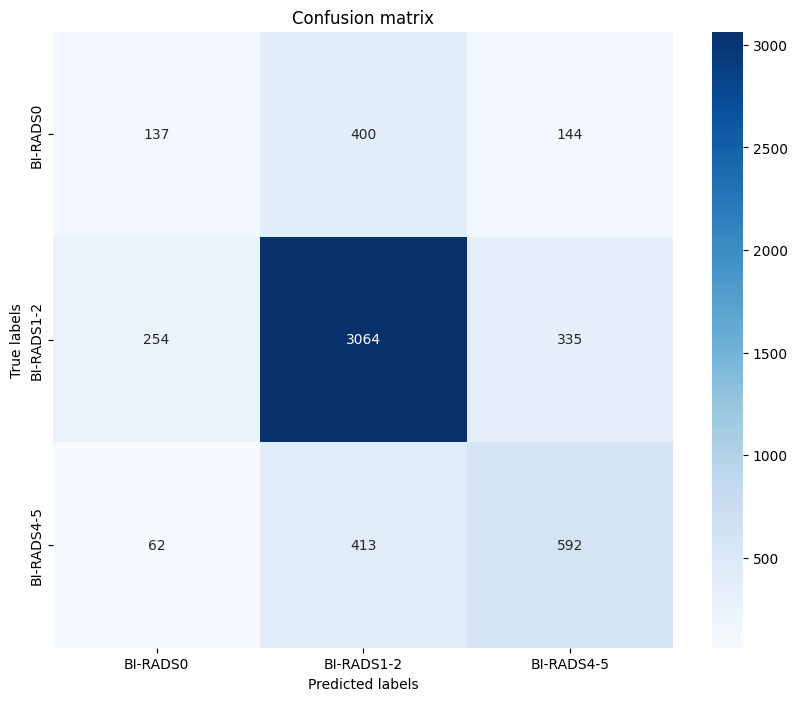


Epoch 5/50
----------


100%|██████████| 5743/5743 [09:26<00:00, 10.14it/s]


train Loss: 0.9528 Acc: 0.5824


100%|██████████| 2700/2700 [01:42<00:00, 26.36it/s]


val Loss: 0.9105 Acc: 0.6340

Epoch 6/50
----------


100%|██████████| 5743/5743 [09:17<00:00, 10.30it/s]


train Loss: 0.9679 Acc: 0.5674


100%|██████████| 2700/2700 [01:42<00:00, 26.40it/s]


val Loss: 0.8914 Acc: 0.6495

Epoch 7/50
----------


100%|██████████| 5743/5743 [09:20<00:00, 10.24it/s]


train Loss: 0.9697 Acc: 0.5643


100%|██████████| 2700/2700 [01:42<00:00, 26.32it/s]


val Loss: 0.9123 Acc: 0.6349

Epoch 8/50
----------


100%|██████████| 5743/5743 [09:22<00:00, 10.20it/s]


train Loss: 0.9674 Acc: 0.5683


100%|██████████| 2700/2700 [01:35<00:00, 28.38it/s]


val Loss: 0.9194 Acc: 0.6245

Epoch 9/50
----------


100%|██████████| 5743/5743 [09:55<00:00,  9.65it/s]


train Loss: 0.9692 Acc: 0.5666


100%|██████████| 2700/2700 [01:42<00:00, 26.39it/s]


val Loss: 0.8715 Acc: 0.6773

Epoch 10/50
----------


100%|██████████| 5743/5743 [09:18<00:00, 10.29it/s]


train Loss: 0.9669 Acc: 0.5693


100%|██████████| 2700/2700 [01:42<00:00, 26.33it/s]


val Loss: 0.8792 Acc: 0.6723

Epoch 11/50
----------


100%|██████████| 5743/5743 [09:19<00:00, 10.26it/s]


train Loss: 0.9617 Acc: 0.5745


100%|██████████| 2700/2700 [01:42<00:00, 26.39it/s]


val Loss: 0.8951 Acc: 0.6519

Epoch 12/50
----------


100%|██████████| 5743/5743 [09:17<00:00, 10.31it/s]


train Loss: 0.9622 Acc: 0.5737


100%|██████████| 2700/2700 [01:42<00:00, 26.29it/s]


val Loss: 0.9167 Acc: 0.6280

Epoch 13/50
----------


100%|██████████| 5743/5743 [09:19<00:00, 10.26it/s]


train Loss: 0.9717 Acc: 0.5635


100%|██████████| 2700/2700 [01:42<00:00, 26.40it/s]


val Loss: 0.8961 Acc: 0.6528

Epoch 14/50
----------


100%|██████████| 5743/5743 [09:16<00:00, 10.33it/s]


train Loss: 0.9692 Acc: 0.5656


100%|██████████| 2700/2700 [01:42<00:00, 26.27it/s]


val Loss: 0.9167 Acc: 0.6303

Epoch 15/50
----------


100%|██████████| 5743/5743 [09:28<00:00, 10.10it/s]


train Loss: 0.9651 Acc: 0.5715


100%|██████████| 2700/2700 [01:33<00:00, 29.03it/s]


val Loss: 0.8953 Acc: 0.6540

Epoch 16/50
----------


100%|██████████| 5743/5743 [09:43<00:00,  9.84it/s]


train Loss: 0.9649 Acc: 0.5710


100%|██████████| 2700/2700 [01:31<00:00, 29.37it/s]


val Loss: 0.8913 Acc: 0.6541

Epoch 17/50
----------


100%|██████████| 5743/5743 [09:45<00:00,  9.81it/s]


train Loss: 0.9633 Acc: 0.5737


100%|██████████| 2700/2700 [01:31<00:00, 29.42it/s]


val Loss: 0.8735 Acc: 0.6743

Epoch 18/50
----------


100%|██████████| 5743/5743 [09:36<00:00,  9.96it/s]


train Loss: 0.9721 Acc: 0.5615


100%|██████████| 2700/2700 [01:42<00:00, 26.40it/s]


val Loss: 0.8841 Acc: 0.6699

Epoch 19/50
----------


100%|██████████| 5743/5743 [09:14<00:00, 10.35it/s]


train Loss: 0.9606 Acc: 0.5744


100%|██████████| 2700/2700 [01:42<00:00, 26.39it/s]


val Loss: 0.8942 Acc: 0.6584

Epoch 20/50
----------


100%|██████████| 5743/5743 [09:16<00:00, 10.33it/s]


train Loss: 0.9670 Acc: 0.5673


100%|██████████| 2700/2700 [01:42<00:00, 26.35it/s]


val Loss: 0.8846 Acc: 0.6628

Epoch 21/50
----------


100%|██████████| 5743/5743 [09:17<00:00, 10.30it/s]


train Loss: 0.9674 Acc: 0.5694


100%|██████████| 2700/2700 [01:42<00:00, 26.27it/s]


val Loss: 0.8750 Acc: 0.6717

Epoch 22/50
----------


100%|██████████| 5743/5743 [09:18<00:00, 10.28it/s]


train Loss: 0.9692 Acc: 0.5676


100%|██████████| 2700/2700 [01:42<00:00, 26.40it/s]


val Loss: 0.8850 Acc: 0.6597

Epoch 23/50
----------


100%|██████████| 5743/5743 [09:25<00:00, 10.15it/s]


train Loss: 0.9611 Acc: 0.5729


100%|██████████| 2700/2700 [01:34<00:00, 28.62it/s]


val Loss: 0.9417 Acc: 0.6034

Epoch 24/50
----------


100%|██████████| 5743/5743 [09:50<00:00,  9.73it/s]


train Loss: 0.9601 Acc: 0.5743


100%|██████████| 2700/2700 [01:32<00:00, 29.33it/s]


val Loss: 0.9028 Acc: 0.6425

Epoch 25/50
----------


100%|██████████| 5743/5743 [09:39<00:00,  9.92it/s]


train Loss: 0.9674 Acc: 0.5660


100%|██████████| 2700/2700 [01:42<00:00, 26.43it/s]


val Loss: 0.9118 Acc: 0.6354

Epoch 26/50
----------


100%|██████████| 5743/5743 [09:17<00:00, 10.30it/s]


train Loss: 0.9695 Acc: 0.5651


100%|██████████| 2700/2700 [01:42<00:00, 26.41it/s]


val Loss: 0.9110 Acc: 0.6340

Epoch 27/50
----------


100%|██████████| 5743/5743 [09:17<00:00, 10.30it/s]


train Loss: 0.9662 Acc: 0.5677


100%|██████████| 2700/2700 [01:42<00:00, 26.30it/s]


val Loss: 0.8795 Acc: 0.6664

Epoch 28/50
----------


100%|██████████| 5743/5743 [09:36<00:00,  9.97it/s]


train Loss: 0.9700 Acc: 0.5656


100%|██████████| 2700/2700 [01:31<00:00, 29.35it/s]


val Loss: 0.8923 Acc: 0.6578

Epoch 29/50
----------


100%|██████████| 5743/5743 [09:54<00:00,  9.65it/s]


train Loss: 0.9668 Acc: 0.5688


100%|██████████| 2700/2700 [01:42<00:00, 26.24it/s]


val Loss: 0.8996 Acc: 0.6515

Epoch 30/50
----------


100%|██████████| 5743/5743 [09:21<00:00, 10.24it/s]


train Loss: 0.9674 Acc: 0.5680


100%|██████████| 2700/2700 [01:42<00:00, 26.40it/s]


val Loss: 0.8801 Acc: 0.6680

Epoch 31/50
----------


100%|██████████| 5743/5743 [09:17<00:00, 10.29it/s]


train Loss: 0.9738 Acc: 0.5589


100%|██████████| 2700/2700 [01:41<00:00, 26.63it/s]


val Loss: 0.9295 Acc: 0.6125

Epoch 32/50
----------


100%|██████████| 5743/5743 [09:03<00:00, 10.57it/s]


train Loss: 0.9721 Acc: 0.5638


100%|██████████| 2700/2700 [01:41<00:00, 26.68it/s]


val Loss: 0.8960 Acc: 0.6475

Epoch 33/50
----------


100%|██████████| 5743/5743 [09:04<00:00, 10.56it/s]


train Loss: 0.9713 Acc: 0.5609


100%|██████████| 2700/2700 [01:32<00:00, 29.05it/s]


val Loss: 0.9307 Acc: 0.6182

Epoch 34/50
----------


100%|██████████| 5743/5743 [09:05<00:00, 10.54it/s]


train Loss: 0.9634 Acc: 0.5702


100%|██████████| 2700/2700 [01:31<00:00, 29.62it/s]


val Loss: 0.8911 Acc: 0.6545

Epoch 35/50
----------


100%|██████████| 5743/5743 [09:01<00:00, 10.60it/s]


train Loss: 0.9643 Acc: 0.5723


100%|██████████| 2700/2700 [01:31<00:00, 29.62it/s]


val Loss: 0.8742 Acc: 0.6804

Epoch 36/50
----------


100%|██████████| 5743/5743 [09:04<00:00, 10.54it/s]


train Loss: 0.9701 Acc: 0.5666


100%|██████████| 2700/2700 [01:41<00:00, 26.62it/s]


val Loss: 0.8913 Acc: 0.6536

Epoch 37/50
----------


100%|██████████| 5743/5743 [09:05<00:00, 10.53it/s]


train Loss: 0.9723 Acc: 0.5632


100%|██████████| 2700/2700 [01:41<00:00, 26.63it/s]


val Loss: 0.9144 Acc: 0.6290

Epoch 38/50
----------


100%|██████████| 5743/5743 [09:07<00:00, 10.50it/s]


train Loss: 0.9585 Acc: 0.5758


100%|██████████| 2700/2700 [01:41<00:00, 26.62it/s]


val Loss: 0.9038 Acc: 0.6441

Epoch 39/50
----------


100%|██████████| 5743/5743 [09:16<00:00, 10.32it/s]


train Loss: 0.9625 Acc: 0.5717


100%|██████████| 2700/2700 [01:57<00:00, 22.91it/s]


val Loss: 0.9190 Acc: 0.6245

Epoch 40/50
----------


100%|██████████| 5743/5743 [09:35<00:00,  9.98it/s]


train Loss: 0.9640 Acc: 0.5711


100%|██████████| 2700/2700 [01:45<00:00, 25.62it/s]


val Loss: 0.8981 Acc: 0.6482

Epoch 41/50
----------


100%|██████████| 5743/5743 [09:18<00:00, 10.29it/s]


train Loss: 0.9704 Acc: 0.5654


100%|██████████| 2700/2700 [01:34<00:00, 28.59it/s]


val Loss: 0.8928 Acc: 0.6530

Epoch 42/50
----------


100%|██████████| 5743/5743 [09:05<00:00, 10.54it/s]


train Loss: 0.9670 Acc: 0.5699


100%|██████████| 2700/2700 [01:32<00:00, 29.15it/s]


val Loss: 0.8817 Acc: 0.6710

Epoch 43/50
----------


100%|██████████| 5743/5743 [09:02<00:00, 10.58it/s]


train Loss: 0.9599 Acc: 0.5773


100%|██████████| 2700/2700 [01:39<00:00, 27.06it/s]


val Loss: 0.8900 Acc: 0.6554

Epoch 44/50
----------


100%|██████████| 5743/5743 [09:07<00:00, 10.48it/s]


train Loss: 0.9617 Acc: 0.5722


100%|██████████| 2700/2700 [01:41<00:00, 26.56it/s]


val Loss: 0.8982 Acc: 0.6473

Epoch 45/50
----------


100%|██████████| 5743/5743 [09:06<00:00, 10.51it/s]


train Loss: 0.9660 Acc: 0.5676


100%|██████████| 2700/2700 [01:41<00:00, 26.60it/s]


val Loss: 0.9192 Acc: 0.6277

Epoch 46/50
----------


100%|██████████| 5743/5743 [09:03<00:00, 10.57it/s]


train Loss: 0.9658 Acc: 0.5686


100%|██████████| 2700/2700 [01:40<00:00, 26.74it/s]


val Loss: 0.9203 Acc: 0.6249

Epoch 47/50
----------


100%|██████████| 5743/5743 [08:58<00:00, 10.66it/s]


train Loss: 0.9672 Acc: 0.5697


100%|██████████| 2700/2700 [01:30<00:00, 29.68it/s]


val Loss: 0.8485 Acc: 0.7067


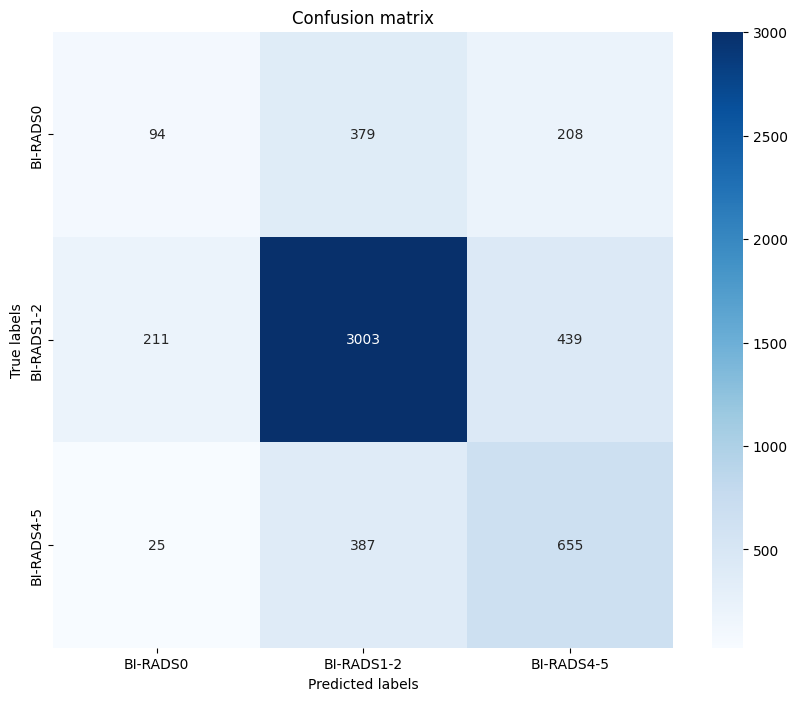


Epoch 48/50
----------


100%|██████████| 5743/5743 [08:58<00:00, 10.66it/s]


train Loss: 0.9633 Acc: 0.5730


100%|██████████| 2700/2700 [01:38<00:00, 27.50it/s]


val Loss: 0.8853 Acc: 0.6638

Epoch 49/50
----------


100%|██████████| 5743/5743 [09:03<00:00, 10.56it/s]


train Loss: 0.9729 Acc: 0.5598


100%|██████████| 2700/2700 [01:41<00:00, 26.56it/s]


val Loss: 0.8998 Acc: 0.6454

Epoch 50/50
----------


100%|██████████| 5743/5743 [09:03<00:00, 10.56it/s]


train Loss: 0.9677 Acc: 0.5676


100%|██████████| 2700/2700 [01:40<00:00, 26.75it/s]


val Loss: 0.8911 Acc: 0.6595

Training complete in 555m 40s
Best val Acc: 0.706721


In [17]:
for name,model in modeller.items(): 
    model_ft = model
    #model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/TEKNOFEST/yen/modelPerformance/vit/best_model_0.7244acc_20epochs.h5')
    
    """
    num_ftrs = model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""

    """ num_ftrs=model.heads[-1].in_features
    model_ft.heads[-1]=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""
    
    num_ftrs=model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

In [18]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):  # draw validation and train accuracy graphs
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                model.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):
    
        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data).cuda().cpu()
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1   
                        if predicted_3[i].item()==0:
                            final_pred[i]=0 

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1                    
                    if a==0:                   
                        final_pred[i]=predicted_2[i] 
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))
    
    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):
        
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0                        
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:                   
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):
    
        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:                   
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    
    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
            label='ROC curve of class {0} (area = {1:0.4f})'
            ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.4f})'
                    ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()



resnet50
-----------------
F1 Score: 0.18595450049455983 0.809215844785772 0.5529759392148587 
Recall: 0.13803230543318648 0.8220640569395018 0.6138706654170571 
Precision: 0.28484848484848485 0.7967630671265588 0.5030721966205837 


Classification Report :
               precision    recall  f1-score   support

           0       0.28      0.14      0.19       681
           1       0.80      0.82      0.81      3653
           2       0.50      0.61      0.55      1067

    accuracy                           0.69      5401
   macro avg       0.53      0.52      0.52      5401
weighted avg       0.67      0.69      0.68      5401

Correct Prediction: 3752  Total Images: 5401
Test Accuracy = 0.694686
Kappa Score of this model:
 0.3540898041001749


Confusion matrix:
 [[  94  379  208]
 [ 211 3003  439]
 [  25  387  655]]




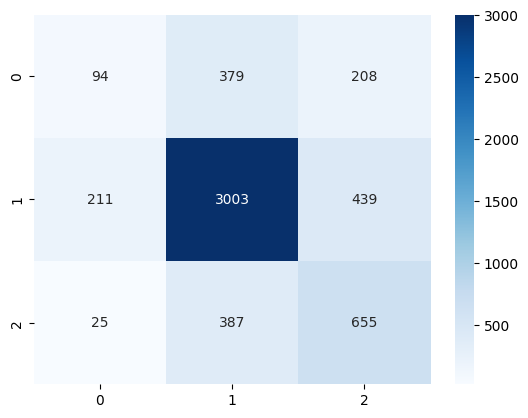

In [19]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
print('\n'+'resnet50'+'\n-----------------')  
model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/birads_split_resnet50/best_model_0.7067acc_50epochs.h5')
phase='val'
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders[phase])
f1=f1_score(predictions,actuals,average=None)
recall=recall_score(actuals,predictions,average=None)
precision=precision_score(actuals,predictions,average=None)
print(f'F1 Score: {f1[0]} {f1[1]} {f1[2]} ')
print(f'Recall: {recall[0]} {recall[1]} {recall[2]} ') 
print(f'Precision: {precision[0]} {precision[1]} {precision[2]} ')
print('\n')
get_metric.get_classification_report(actuals, predictions)
get_metric.test_model(model_ft,device,dataloaders[phase])
get_metric.get_cohen_kappa(actuals, predictions)
print('\n')
get_metric.get_confusion_matrix(actuals, predictions)
print('\n')
#get_metric.get_roc_curves(model_ft, device,  dataloaders[phase])